Loaded scaler and LSTM autoencoder.
Generated 6463 sequences.
Calculated anomaly scores.
Optimization done.
Recommended Critical Threshold: 18.622056
Recommended Warning Threshold: 4.605824
              precision    recall  f1-score   support

    Critical       0.08      0.47      0.13        17
     Warning       0.09      0.26      0.13        31
      Normal       1.00      0.97      0.99      6415

    accuracy                           0.97      6463
   macro avg       0.39      0.57      0.42      6463
weighted avg       0.99      0.97      0.98      6463



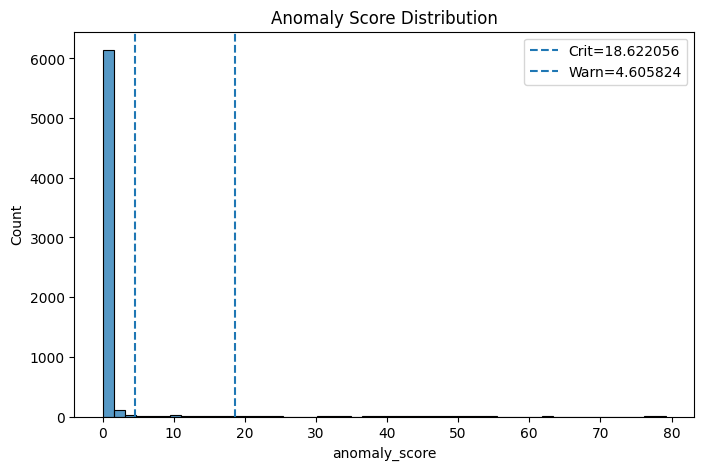

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# --- Configuration ---
SEQUENCE_LENGTH = 30
NUMERICAL_COLS = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']
LABEL_ORDER = ['Critical', 'Warning', 'Normal']
SCALER_PATH = 'scaler_fit.save'
MODEL_PATH = 'lstm_autoencoder_model_fit.h5'
VALIDATION_FILES = ['./../../data/dev101_resample10T_flex.csv',
                    './../../data/dev102_resample10T_flex.csv']

# --- Helpers ---
def create_sequences_by_device(df, seq_len, cols, return_index=False):
    sequences, device_ids, timestamps, indices = [], [], [], []
    scaled_cols = [f'scaled_{c}' for c in cols]
    for dev, grp in df.groupby('devID'):
        grp = grp.sort_values('timestamp')
        vals = grp[scaled_cols].values
        times = grp['timestamp'].values
        idxs = grp.index.values
        for i in range(len(vals) - seq_len + 1):
            sequences.append(vals[i:i+seq_len])
            device_ids.append(dev)
            timestamps.append(times[i+seq_len-1])
            if return_index:
                indices.append(idxs[i+seq_len-1])
    if return_index:
        return np.array(sequences), device_ids, timestamps, indices
    return np.array(sequences), device_ids, timestamps


def classify_risk(scores, crit_thr, warn_thr):
    conds = [scores > crit_thr,
             (scores <= crit_thr) & (scores > warn_thr),
             scores <= warn_thr]
    return np.select(conds, LABEL_ORDER, default='Normal')


def evaluate_thresholds(df, crit_thr, warn_thr):
    y_pred = classify_risk(df['anomaly_score'], crit_thr, warn_thr)
    y_true = df['true_label']
    f1_w = f1_score(y_true, y_pred, average='weighted', labels=LABEL_ORDER)
    f1_m = f1_score(y_true, y_pred, average='macro', labels=LABEL_ORDER)
    f1_c = f1_score(y_true, y_pred, average=None, labels=LABEL_ORDER)
    f1_min = f1_c.min()
    f1_h = len(f1_c) / np.sum(1.0 / (f1_c + 1e-8))
    return {'f1_weighted': f1_w, 'f1_macro': f1_m,
            'f1_per_class': f1_c, 'f1_min': f1_min,
            'f1_harmonic': f1_h, 'y_pred': y_pred}

# --- Load scaler & model ---
scaler = joblib.load(SCALER_PATH)
model = load_model(MODEL_PATH, compile=False)
print("Loaded scaler and LSTM autoencoder.")

# --- Load and preprocess validation data ---
frames = [pd.read_csv(f) for f in VALIDATION_FILES]
df_val = pd.concat(frames, ignore_index=True)
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_val = df_val.sort_values('timestamp').reset_index(drop=True)
# Fill missing labels as 'Normal'
df_val['label'] = df_val['label'].fillna('Normal')

# Scale features
scaled = scaler.transform(df_val[NUMERICAL_COLS])
for i, c in enumerate(NUMERICAL_COLS):
    df_val[f'scaled_{c}'] = scaled[:, i]

# Create sequences
X_val, dev_ids, times, idxs = create_sequences_by_device(df_val, SEQUENCE_LENGTH, NUMERICAL_COLS, return_index=True)
print(f"Generated {len(X_val)} sequences.")

# Reconstruction and scoring
recon = model.predict(X_val, verbose=0)
anom_scores = np.mean((X_val - recon)**2, axis=(1,2))

# Build results DataFrame
df_seq = pd.DataFrame({'devID': dev_ids, 'timestamp': times, 'index': idxs})
# Map true labels
df_seq['true_label'] = df_val.loc[df_seq['index'], 'label'].replace(
    {'critical':'Critical', 'warning':'Warning', 'normal':'Normal'}).values
df_seq['anomaly_score'] = anom_scores
df_seq = df_seq[df_seq['true_label'].isin(LABEL_ORDER)]
print("Calculated anomaly scores.")

# --- Threshold grid search ---
s_min, s_max = df_seq['anomaly_score'].min(), df_seq['anomaly_score'].max()
percentiles = np.linspace(0.1, 99.9, 200)
cands = np.percentile(df_seq['anomaly_score'], percentiles)
# add fine offsets around high percentiles
for p in [90,95,97,99]:
    v = np.percentile(df_seq['anomaly_score'], p)
    rng = s_max - s_min
    cands = np.concatenate([cands, v + np.array([-0.01,0,0.01])*rng])
cands = np.unique(np.clip(cands, s_min, s_max))

best = {'balanced': {'score':0}}
# search
for crit in cands:
    for warn in cands:
        if warn >= crit: continue
        res = evaluate_thresholds(df_seq, crit, warn)
        bal = 0.6*res['f1_min'] + 0.4*res['f1_harmonic']
        if bal > best['balanced']['score']:
            best['balanced'].update({'score': bal, 'crit': crit, 'warn': warn, 'res': res})
print("Optimization done.")

# --- Results ---
opt = best['balanced']
print(f"Recommended Critical Threshold: {opt['crit']:.6f}")
print(f"Recommended Warning Threshold: {opt['warn']:.6f}")
print(classification_report(df_seq['true_label'], opt['res']['y_pred'], labels=LABEL_ORDER))

# --- Visualization ---
def plot_results():
    plt.figure(figsize=(8,5))
    sns.histplot(df_seq['anomaly_score'], bins=50, kde=False)
    plt.axvline(opt['crit'], linestyle='--', label="Crit={:.6f}".format(opt['crit']))
    plt.axvline(opt['warn'], linestyle='--', label="Warn={:.6f}".format(opt['warn']))
    plt.legend(); plt.title('Anomaly Score Distribution')
    plt.show()

plot_results()
